In [47]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import time
import torchvision.utils as vutils

from torchvision import datasets, transforms
from draw_model import DRAWModel
from dataloader import get_data

In [48]:
params = {
    'T' : 25,# Number of glimpses.
    'batch_size': 10,# Batch size.
    'A' : 32,# Image width
    'B': 32,# Image height
    'z_size' :100,# Dimension of latent space.
    'read_N' : 6,# N x N dimension of reading glimpse.
    'write_N' : 6,# N x N dimension of writing glimpse.
    'dec_size': 400,# Hidden dimension for decoder.
    'enc_size' :400,# Hidden dimension for encoder.
    'epoch_num': 50,# Number of epochs to train for.
    'learning_rate': 1e-3,# Learning rate.
    'beta1': 0.5,
    'clip': 5.0,
    'save_epoch' : 10,# After how many epochs to save checkpoints and generate test output.
    'channel' : None}# Number of channels for image.(3 for RGB, etc.)



In [49]:
torch.cuda.is_available()

True

In [50]:
torch.cuda.current_device()


0

In [51]:
device = torch.cuda.device(0)
params['device'] = device

In [52]:
device

In [53]:
# Function to generate new images and save the time-steps as an animation.
def generate_image(epoch):
    x = model.generate(64)
    fig = plt.figure(figsize=(16, 16))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in x]
    anim = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)
    anim.save('draw_epoch_{}.gif'.format(epoch), dpi=100, writer='imagemagick')
    plt.close('all')

In [54]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as dset



root = 'testData/DNIM/Image'
 # Data proprecessing.
transform = transforms.Compose([
    transforms.Resize(params['A']),
    transforms.CenterCrop(params['A']),
    transforms.ToTensor()])
    
#     imagenet_data = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
# data_loader = torch.utils.data.DataLoader(imagenet_data,
#                                           batch_size=4,
#                                           shuffle=True,
#                                           num_workers=args.nThreads)

# Create the dataset.
dataset = dset.ImageFolder(root=root, transform=transform)

# Create the dataloader.
train_loader = torch.utils.data.DataLoader(dataset,
    batch_size=params['batch_size'],
    shuffle=False)


params['channel'] = 3


In [55]:
# Plot the training images.
sample_batch = next(iter(train_loader))



In [56]:
sample_batch[0]

tensor([[[[0.1294, 0.1333, 0.1333,  ..., 0.1373, 0.1294, 0.1294],
          [0.1255, 0.1216, 0.1255,  ..., 0.1294, 0.1255, 0.1255],
          [0.1176, 0.1176, 0.1216,  ..., 0.1294, 0.1255, 0.1255],
          ...,
          [0.7333, 0.6627, 0.5804,  ..., 0.0510, 0.0471, 0.0510],
          [0.5804, 0.5255, 0.4510,  ..., 0.0588, 0.0667, 0.0706],
          [0.2902, 0.2510, 0.2039,  ..., 0.0667, 0.0588, 0.0667]],

         [[0.0627, 0.0667, 0.0667,  ..., 0.0667, 0.0667, 0.0627],
          [0.0549, 0.0588, 0.0627,  ..., 0.0667, 0.0627, 0.0627],
          [0.0510, 0.0549, 0.0588,  ..., 0.0627, 0.0627, 0.0627],
          ...,
          [0.3255, 0.2941, 0.2588,  ..., 0.0353, 0.0392, 0.0392],
          [0.2588, 0.2353, 0.2000,  ..., 0.0392, 0.0510, 0.0471],
          [0.1294, 0.1137, 0.0941,  ..., 0.0431, 0.0431, 0.0471]],

         [[0.0353, 0.0353, 0.0353,  ..., 0.0314, 0.0314, 0.0314],
          [0.0431, 0.0392, 0.0353,  ..., 0.0314, 0.0275, 0.0275],
          [0.0431, 0.0392, 0.0353,  ..., 0

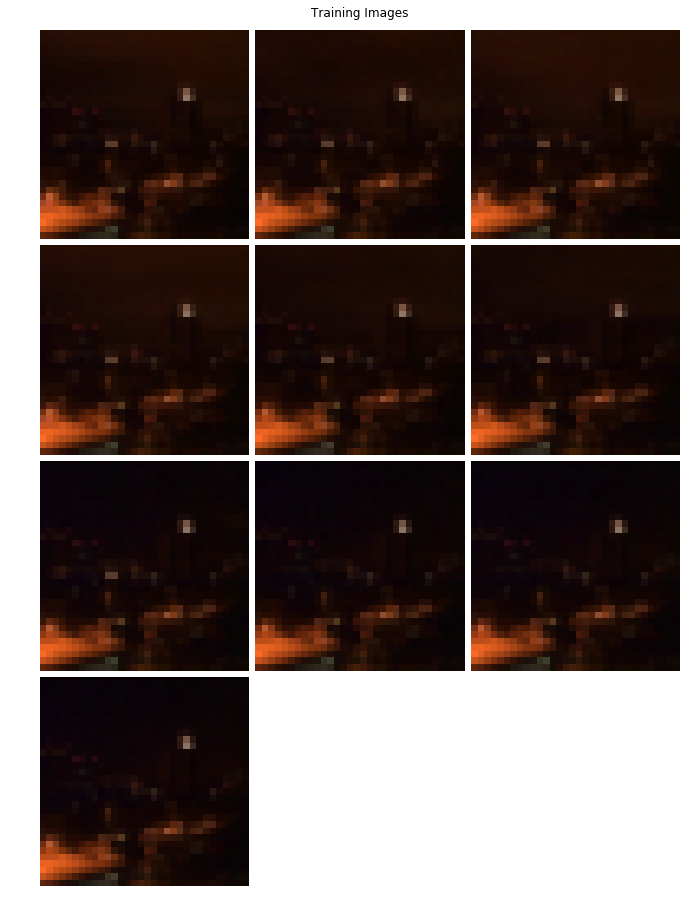

In [57]:
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0][ : 64], nrow=3, padding=1, normalize=True, pad_value=1).cpu(), (1, 2, 0)))
plt.savefig("Training_Data")


In [58]:
print (torch.__version__)

0.4.1


In [ ]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import numpy as np

"""
The equation numbers on the comments corresponding
to the relevant equation given in the paper:
DRAW: A Recurrent Neural Network For Image Generation.
"""

class DRAWModel(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.T = params['T']
        self.A = params['A']
        self.B = params['B']
        self.z_size = params['z_size']
        self.read_N = params['read_N']
        self.write_N = params['write_N']
        self.enc_size = params['enc_size']
        self.dec_size = params['dec_size']
        self.channel = params['channel']

        # Stores the generated image for each time step.
        self.cs = [0] * self.T
        
        # To store appropriate values used for calculating the latent loss (KL-Divergence loss)
        self.logsigmas = [0] * self.T
        self.sigmas = [0] * self.T
        self.mus = [0] * self.T

        self.encoder = nn.LSTMCell(2*self.read_N*self.read_N*self.channel + self.dec_size, self.enc_size)

        # To get the mean and standard deviation for the distribution of z.
        self.fc_mu = nn.Linear(self.enc_size, self.z_size)
        self.fc_sigma = nn.Linear(self.enc_size, self.z_size)

        self.decoder = nn.LSTMCell(self.z_size, self.dec_size)

        self.fc_write = nn.Linear(self.dec_size, self.write_N*self.write_N*self.channel)

        # To get the attention parameters. 5 in total.
        self.fc_attention = nn.Linear(self.dec_size, 5)

    def forward(self, x):
        self.batch_size = x.size(0)

        # requires_grad should be set True to allow backpropagation of the gradients for training.
        h_enc_prev = torch.zeros(self.batch_size, self.enc_size, requires_grad=True)
        h_dec_prev = torch.zeros(self.batch_size, self.dec_size, requires_grad=True)

        enc_state = torch.zeros(self.batch_size, self.enc_size, requires_grad=True)
        dec_state = torch.zeros(self.batch_size, self.dec_size, requires_grad=True)

        for t in range(self.T):
            c_prev = torch.zeros(self.batch_size, self.B*self.A*self.channel, requires_grad=True) if t == 0 else self.cs[t-1]
            # Equation 3.
            x_hat = x - torch.sigmoid(c_prev)
            # Equation 4.
            # Get the N x N glimpse.
            r_t = self.read(x, x_hat, h_dec_prev)
            # Equation 5.
            h_enc, enc_state = self.encoder(torch.cat((r_t, h_dec_prev), dim=1), (h_enc_prev, enc_state))
            # Equation 6.
            z, self.mus[t], self.logsigmas[t], self.sigmas[t] = self.sampleQ(h_enc)
            # Equation 7.
            h_dec, dec_state = self.decoder(z, (h_dec_prev, dec_state))
            # Equation 8.
            self.cs[t] = c_prev + self.write(h_dec)

            h_enc_prev = h_enc
            h_dec_prev = h_dec

    def read(self, x, x_hat, h_dec_prev):
        # Using attention
        (Fx, Fy), gamma = self.attn_window(h_dec_prev, self.read_N)

        def filter_img(img, Fx, Fy, gamma):
            Fxt = Fx.transpose(self.channel, 2)
            if self.channel == 3:
                img = img.view(-1, 3, self.B, self.A)
            elif self.channel == 1:
                img = img.view(-1, self.B, self.A)

            # Equation 27.
            glimpse = torch.matmul(Fy, torch.matmul(img, Fxt))
            glimpse = glimpse.view(-1, self.read_N*self.read_N*self.channel)

            return glimpse * gamma.view(-1, 1).expand_as(glimpse)

        x = filter_img(x, Fx, Fy, gamma)
        x_hat = filter_img(x_hat, Fx, Fy, gamma)

        return torch.cat((x, x_hat), dim=1)
        # No attention
        #return torch.cat((x, x_hat), dim=1)

    def write(self, h_dec):
        # Using attention
        # Equation 28.
        w = self.fc_write(h_dec)
        if self.channel == 3:
            w = w.view(self.batch_size, 3, self.write_N, self.write_N)
        elif self.channel == 1:
            w = w.view(self.batch_size, self.write_N, self.write_N)

        (Fx, Fy), gamma = self.attn_window(h_dec, self.write_N)
        Fyt = Fy.transpose(self.channel, 2)

        # Equation 29.
        wr = torch.matmul(Fyt, torch.matmul(w, Fx))
        wr = wr.view(self.batch_size, self.B*self.A*self.channel)

        return wr / gamma.view(-1, 1).expand_as(wr)
        # No attention
        #return self.fc_write(h_dec)

    def sampleQ(self, h_enc):
        e = torch.randn(self.batch_size, self.z_size)

        # Equation 1.
        mu = self.fc_mu(h_enc)
        # Equation 2.
        log_sigma = self.fc_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        
        z = mu + e * sigma

        return z, mu, log_sigma, sigma

    def attn_window(self, h_dec, N):
        # Equation 21.
        params = self.fc_attention(h_dec)
        gx_, gy_, log_sigma_2, log_delta_, log_gamma = params.split(1, 1)

        # Equation 22.
        gx = (self.A + 1) / 2 * (gx_ + 1)
        # Equation 23
        gy = (self.B + 1) / 2 * (gy_ + 1)
        # Equation 24.
        delta = (max(self.A, self.B) - 1) / (N - 1) * torch.exp(log_delta_)
        sigma_2 = torch.exp(log_sigma_2)
        gamma = torch.exp(log_gamma)

        return self.filterbank(gx, gy, sigma_2, delta, N), gamma

    def filterbank(self, gx, gy, sigma_2, delta, N, epsilon=1e-8):
        grid_i = torch.arange(start=0.0, end=N, requires_grad=True,).view(1, -1)
        
        # Equation 19.
        mu_x = gx + (grid_i - N / 2 - 0.5) * delta
        # Equation 20.
        mu_y = gy + (grid_i - N / 2 - 0.5) * delta

        a = torch.arange(0.0, self.A, requires_grad=True).view(1, 1, -1)
        b = torch.arange(0.0, self.B, requires_grad=True).view(1, 1, -1)

        mu_x = mu_x.view(-1, N, 1)
        mu_y = mu_y.view(-1, N, 1)
        sigma_2 = sigma_2.view(-1, 1, 1)

        # Equations 25 and 26.
        Fx = torch.exp(-torch.pow(a - mu_x, 2) / (2 * sigma_2))
        Fy = torch.exp(-torch.pow(b - mu_y, 2) / (2 * sigma_2))

        Fx = Fx / (Fx.sum(2, True).expand_as(Fx) + epsilon)
        Fy = Fy / (Fy.sum(2, True).expand_as(Fy) + epsilon)

        if self.channel == 3:
            Fx = Fx.view(Fx.size(0), 1, Fx.size(1), Fx.size(2))
            Fx = Fx.repeat(1, 3, 1, 1)
            
            Fy = Fy.view(Fy.size(0), 1, Fy.size(1), Fy.size(2))
            Fy = Fy.repeat(1, 3, 1, 1)

        return Fx, Fy

    def loss(self, x):
        self.forward(x)

        criterion = nn.BCELoss()
        x_recon = torch.sigmoid(self.cs[-1])
        # Reconstruction loss.
        # Only want to average across the mini-batch, hence, multiply by the image dimensions.
        Lx = criterion(x_recon, x) * self.A * self.B * self.channel
        # Latent loss.
        Lz = 0

        for t in range(self.T):
            mu_2 = self.mus[t] * self.mus[t]
            sigma_2 = self.sigmas[t] * self.sigmas[t]
            logsigma = self.logsigmas[t]

            kl_loss = 0.5*torch.sum(mu_2 + sigma_2 - 2*logsigma, 1) - 0.5*self.T
            Lz += kl_loss

        Lz = torch.mean(Lz)
        net_loss = Lx + Lz

        return net_loss

    def generate(self, num_output):
        self.batch_size = num_output
        h_dec_prev = torch.zeros(num_output, self.dec_size)
        dec_state = torch.zeros(num_output, self.dec_size)

        for t in range(self.T):
            c_prev = torch.zeros(self.batch_size, self.B*self.A*self.channel) if t == 0 else self.cs[t-1]
            z = torch.randn(self.batch_size, self.z_size)
            h_dec, dec_state = self.decoder(z, (h_dec_prev, dec_state))
            self.cs[t] = c_prev + self.write(h_dec)
            h_dec_prev = h_dec

        imgs = []

        for img in self.cs:
            # The image dimesnion is B x A (According to the DRAW paper).
            img = img.view(-1, self.channel, self.B, self.A)
            imgs.append(vutils.make_grid(torch.sigmoid(img).detach().cpu(), nrow=int(np.sqrt(int(num_output))), padding=1, normalize=True, pad_value=1))

        return imgs

In [ ]:
# Initialize the model.
model = DRAWModel(params)
# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], betas=(params['beta1'], 0.999))

# List to hold the losses for each iteration.
# Used for plotting loss curve.
losses = []
iters = 0
avg_loss = 0

print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nBatch Size: %d\nLength of Data Loader: %d' % (params['epoch_num'], params['batch_size'], len(train_loader)))
print("-"*25)

start_time = time.time()

for epoch in range(params['epoch_num']):
    epoch_start_time = time.time()
    
    for i, (data, _ ) in enumerate(train_loader, 0):
        # Get batch size.
        bs = data.size(0)
        # Flatten the image.
        data = data.view(bs, -1)
        optimizer.zero_grad()
        # Calculate the loss.
        loss = model.loss(data)
        loss_val = loss.cpu().data.numpy()
        avg_loss += loss_val
        # Calculate the gradients.
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), params['clip'])
        # Update parameters.
        optimizer.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch+1, params['epoch_num'], i, len(train_loader), avg_loss / 100))

            avg_loss = 0
        
        losses.append(loss_val)
        iters += 1

    avg_loss = 0
    epoch_time = time.time() - epoch_start_time
    print("Time Taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Save checkpoint and generate test output.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'model' : model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'params' : params
            }, 'checkpoint/model_epoch_{}'.format(epoch+1))
        
        with torch.no_grad():
            generate_image(epoch+1)

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)
# Save the final trained network paramaters.
torch.save({
    'model' : model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'params' : params
    }, 'checkpoint/model_final'.format(epoch))

# Generate test output.
with torch.no_grad():
    generate_image(params['epoch_num'])

# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.savefig("Loss_Curve")

-------------------------
Starting Training Loop...

Epochs: 50
Batch Size: 10
Length of Data Loader: 126
-------------------------
[1/50][100/126]	Loss: 2912.4546
Time Taken for Epoch 1: 47.91s
[2/50][100/126]	Loss: 2659.8755
Time Taken for Epoch 2: 45.07s
[3/50][100/126]	Loss: 2623.9007
Time Taken for Epoch 3: 43.30s
[4/50][100/126]	Loss: 2609.4283
Time Taken for Epoch 4: 43.81s
[5/50][100/126]	Loss: 2603.3216
Time Taken for Epoch 5: 44.84s
[6/50][100/126]	Loss: 2596.4531
Time Taken for Epoch 6: 43.79s
[7/50][100/126]	Loss: 2589.4901
Time Taken for Epoch 7: 44.00s
[8/50][100/126]	Loss: 2584.1039
Time Taken for Epoch 8: 45.31s
[9/50][100/126]	Loss: 2576.8248
Time Taken for Epoch 9: 45.61s
[10/50][100/126]	Loss: 2573.6271
Time Taken for Epoch 10: 43.17s
[11/50][100/126]	Loss: 2567.4209
Time Taken for Epoch 11: 43.40s
[12/50][100/126]	Loss: 2563.1650
Time Taken for Epoch 12: 47.19s
[13/50][100/126]	Loss: 2560.6208
Time Taken for Epoch 13: 42.86s
[14/50][100/126]	Loss: 2558.0225
Time Tak